In [0]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import torch.nn as nn
import torch.nn.functional as F

from skimage.color import rgb2gray

import PIL
from PIL import Image

from google.colab import output

In [41]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

/content


In [0]:
class ORCDataset(Dataset):
  def __init__(self, root):
    self.root = root

  def __len__(self):
    lt = 0
    classes = os.listdir(self.root)
    for cl in classes:
      lt += len(os.listdir(self.root + '/' + cl))

    return lt

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
     idx = idx.tolist()

    if(idx <= len(self)):
      found_file = ""
      found_type = ""

      fldrs = os.listdir(self.root)
      for fld in fldrs:
        fls = os.listdir(self.root + '/' + fld + '/')
        for fl in fls:
          if(fl == str(idx) + ".jpg"):
            found_file = self.root + '/' + fld + '/' + fl         
            found_type = fld

      try:
        img = io.imread(found_file)
        img = rgb2gray(img)

        return {'image': img, 'class_name': found_type}
      except:
        if(found_file != ""):
          print("Bad file: " + found_file)
        else:
          print("File not found, idx = " + str(idx))
    else:
      print()
      raise Exception("Dataset index out of boundaries")

train_dataset = ORCDataset('/content/Lithuanian_OCR/Data/training')
val_dataset = ORCDataset('/content/Lithuanian_OCR/Data/val')
test_dataset = ORCDataset('/content/Lithuanian_OCR/Data/test')

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, hidden3_size)
        self.relu3 = nn.ReLU()      
        self.fc4 = nn.Linear(hidden3_size, hidden4_size)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden4_size, hidden5_size)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden5_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)
        out = self.fc3(out)        
        out = self.relu3(out)
        out = self.fc4(out)        
        out = self.relu4(out)
        out = self.fc5(out)        
        out = self.relu5(out)
        out = self.fc6(out)
        return out

In [44]:
network = Net(4096, 2500, 1500, 500, 100, 50, 3)
optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.6)
criterion = nn.MSELoss()

print(network)

Net(
  (fc1): Linear(in_features=4096, out_features=2500, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=2500, out_features=1500, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=1500, out_features=500, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=500, out_features=100, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=100, out_features=50, bias=True)
  (relu5): ReLU()
  (fc6): Linear(in_features=50, out_features=3, bias=True)
)


In [45]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
network.to(dev)
dev

device(type='cpu')

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_dataset),shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = len(val_dataset), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True)

Class name: A


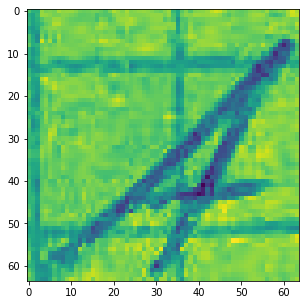

In [47]:
dataiter = iter(train_loader)
itr = dataiter.next()

label = itr['class_name']
img = itr['image']
print("Class name: {}".format(label[0]))

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img[0])

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(10 + 1)]

In [49]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [0]:
def name_to_int(data):

  switcher = {
      'a': 1,
      'a2': 2,
      'b': 3,
      'c': 4,
      'c2': 5,
      'd': 6,
      'e': 7,
      'e2': 8,
      'e3': 9,
      'f': 10,
      'g': 11,
      'h': 12,
      'i': 13,
      'i2': 14,
      'j': 15,
      'k': 16,
      'l': 17,
      'm': 18,
      'n': 19,
      'y': 20,
      'A': 1,
      'B': 2,
      'C': 3
  }

  new_data = []

  for dt in data:
    new_data.append(switcher.get(dt))

  return new_data

In [0]:
def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

In [52]:
def train(train_loader, val_loader, epoch_amount, save_checkpoint = 10):
  network.eval()
  train_loss_hist = []
  val_loss_hist = []
  checkpoint = save_checkpoint
  for epoch in range(epoch_amount):
    num_images_train = 0
    num_images_val = 0

    # TRAINING DATASET
    correct = 0
    for data in train_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      num_images_train = len(images)

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].flatten().float())

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.zeros(3)
        real_value[labels[idx] - 1] = 1

        loss = criterion(outputs, torch.Tensor(real_value)) 
        
        loss.backward()

        lossSum += loss.item()
        train_loss_hist.append(lossSum)

        optimizer.step()

    # VALIDATION
    for data in val_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      num_images_val = len(images)

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].flatten().float())

        if(labels[idx] == get_max_from_tensor(outputs)):
          correct += 1

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.zeros(3)
        real_value[labels[idx] - 1] = 1
        loss = criterion(outputs, torch.Tensor(real_value)) 

        lossSum += loss.item()
        val_loss_hist.append(lossSum)

    print("Epoch: {} Training loss: {} Eval loss: {} Correct: {}%".format(epoch,train_loss_hist[len(train_loss_hist) - 1],val_loss_hist[len(val_loss_hist) - 1],correct*100/num_images_train))

    if(checkpoint == 0):
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

      checkpoint = save_checkpoint
    else:
      checkpoint -= 1

train(train_loader, val_loader, 100)

Epoch: 0 Training loss: 27.846814960241318 Eval loss: 7.694365605711937 Correct: 13.675213675213675%
Epoch: 1 Training loss: 25.277006149291992 Eval loss: 7.6065447479486465 Correct: 13.675213675213675%
Epoch: 2 Training loss: 24.996320597827435 Eval loss: 7.408233404159546 Correct: 13.675213675213675%
Epoch: 3 Training loss: 24.340791027992964 Eval loss: 7.225832752883434 Correct: 13.675213675213675%
Epoch: 4 Training loss: 23.548913292586803 Eval loss: 6.897564128041267 Correct: 13.675213675213675%
Epoch: 5 Training loss: 22.629681738093495 Eval loss: 6.90874707698822 Correct: 13.675213675213675%
Epoch: 6 Training loss: 20.080137685872614 Eval loss: 5.163441494107246 Correct: 21.367521367521366%
Epoch: 7 Training loss: 17.070093226153404 Eval loss: 4.227469710633159 Correct: 23.076923076923077%
Epoch: 8 Training loss: 15.003140891902149 Eval loss: 4.200137384235859 Correct: 25.641025641025642%
Epoch: 9 Training loss: 13.79491046955809 Eval loss: 3.8147809561342 Correct: 23.9316239316

KeyboardInterrupt: ignored

In [57]:
for data in test_loader:
  images = data['image']
  labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

  for i in range(len(images)):
    output = network(images[i].flatten().float())
    
    if(get_max_from_tensor(output) == labels[i]):
      print("OK: {} == {}".format(get_max_from_tensor(output), labels[i]))
    else:
      print("False: {} == {}".format(get_max_from_tensor(output), labels[i]))

OK: 2 == 2
OK: 2 == 2
OK: 2 == 2
OK: 1 == 1
OK: 1 == 1
OK: 1 == 1
OK: 1 == 1
OK: 3 == 3
OK: 2 == 2
OK: 1 == 1
OK: 1 == 1
OK: 3 == 3
OK: 2 == 2
OK: 1 == 1
OK: 3 == 3
OK: 3 == 3
